# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [1]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio.v3 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [2]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2024-02-23 11:44:04--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2024-02-23 11:44:04--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucba7c501a4e7a7e02f019b911f1.dl.dropboxusercontent.com/cd/0/inline/CN0Lp4XK2jIM4dBl27frQlbYIO2xxlxJQIKi3X9J95uzvDbiPsH9Es777klukNy5GYyVsw3uFbzpO2JMqAE8Mpvbx0CAPmPqBKMTO84TJ482t54aixB_hT4PCvHw56hq6ow/file# [following]
--2024-02-23 11:44:04--  https://ucba7c501a4e7a7e02f019b911f1.dl.dropboxusercontent.com/cd/0/inline/CN0Lp4XK2jIM4dBl27frQlbYIO2xxlxJQIKi3X9J95uzvDbiPsH9Es777klukNy5GYyVsw3uFbzpO2JMqAE8Mpvbx0CAPmPqBKMTO

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

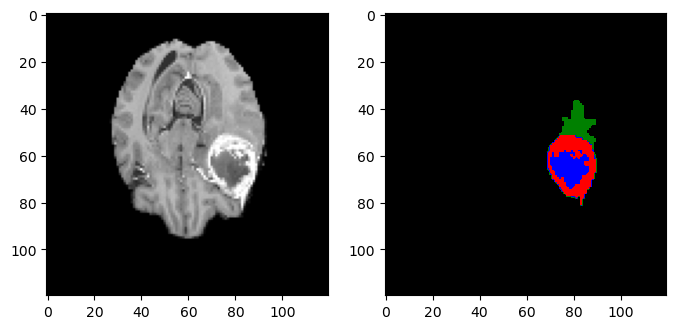

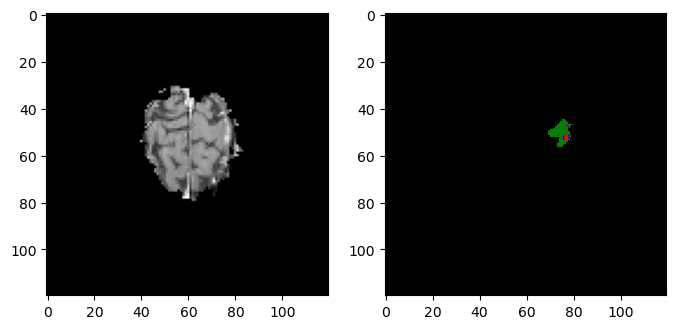

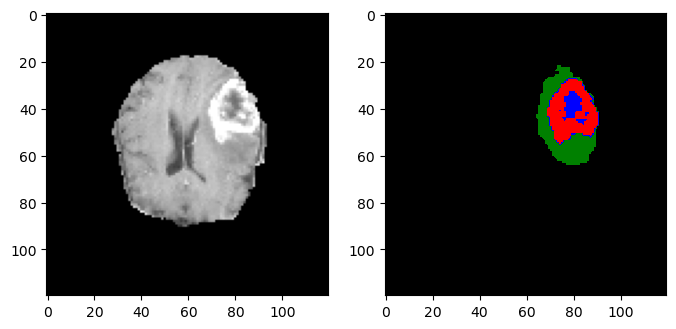

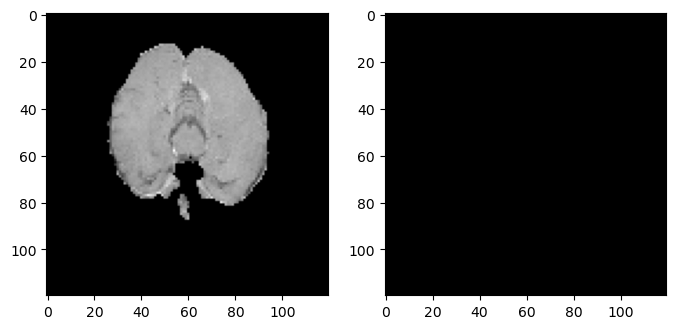

In [3]:
### Insert your code ###
training_image_folder : str = "./Task01_BrainTumour_2D/training_images/"
training_label_folder : str = "./Task01_BrainTumour_2D/training_labels/"
random_images : list[str] = ["BRATS_001_z62.png", "BRATS_044_z124.png", "BRATS_172_z93.png", "BRATS_442_z46.png"]

for image in random_images:
    training_image_path : str = training_image_folder + image
    training_label_path : str = training_label_folder + image
    training_image = imageio.imread(training_image_path)
    training_label = imageio.imread(training_label_path)
    
    plt.figure(figsize=(8, 4))  
    
    # Plot the training image in the first column
    plt.subplot(1, 2, 1)
    plt.imshow(training_image, cmap='gray')
    
    # Plot the training label in the second column
    plt.subplot(1, 2, 2)
    plt.imshow(training_label, cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
    
    plt.show()

### End of your code ###

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [4]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))

            self.images += [image]
            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        random_indices = random.sample(range(self.__len__()), batch_size)
        for index in random_indices:
            image, label = self.__getitem__(index)
            # Add a channel dimension to images and labels if necessary
            image = image.reshape(1, image.shape[0], image.shape[1])
            if not self.deploy:
                label = label.reshape(1, label.shape[0], label.shape[1])
            images.append(image)
            labels.append(label)

        # Stack along the first dimension to form a batch
        images = np.stack(images, axis=0)
        labels = np.stack(labels, axis=0) if not self.deploy else None
        ### End of your code ###
        return images, labels

## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [5]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )
        
        # Decoder path
        ### Insert your code ###
        

        self.upconv4 = nn.ConvTranspose2d(n, n // 2, kernel_size=2, stride=2)
        self.conv_decode3 = nn.Sequential(
            nn.Conv2d(n, n // 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(n // 2, n // 2, kernel_size=3, padding=1),
            nn.ReLU()
        )

        n //= 2  # 64
        self.upconv3 = nn.ConvTranspose2d(n, n // 2, kernel_size=2, stride=2)
        self.conv_decode2 = nn.Sequential(
            nn.Conv2d(n, n // 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(n // 2, n // 2, kernel_size=3, padding=1),
            nn.ReLU()
        )

        n //= 2  # 32
        self.upconv2 = nn.ConvTranspose2d(n, n // 2, kernel_size=2, stride=2)
        self.conv_decode1 = nn.Sequential(
            nn.Conv2d(n, n // 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(n // 2, n // 2, kernel_size=3, padding=1),
            nn.ReLU()
        )

        n //= 2  # 16
        self.final = nn.Conv2d(n, output_channel, kernel_size=1)

    
        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###
        x = self.upconv4(x)
        x = torch.cat([x, conv3_skip], dim=1)
        x = self.conv_decode3(x)
        
        x = self.upconv3(x)
        x = torch.cat([x, conv2_skip], dim=1)
        x = self.conv_decode2(x)
        
        x = self.upconv2(x)
        x = torch.cat([x, conv1_skip], dim=1)
        x = self.conv_decode1(x)
        
        x = self.final(x)
        
        ### End of your code ###

        return x

## 4. Train the segmentation model.

In [40]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    optimizer.zero_grad()
    labels = labels.squeeze(1)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()
    ### End of your code ###

    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            test_images, test_labels = test_set.get_random_batch(eval_batch_size)
            test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
            test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)
            logits = model(test_images)
            test_labels = test_labels.squeeze(1)
            test_loss = criterion(logits, test_labels)
            print(f"Iteration {it}, Test Loss: {test_loss.item()}")
            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cpu
Iteration 100, Test Loss: 0.11501646041870117
Iteration 200, Test Loss: 0.056781966239213943
Iteration 300, Test Loss: 0.09745530784130096
Iteration 400, Test Loss: 0.0776311382651329
Iteration 500, Test Loss: 0.08396006375551224
Iteration 600, Test Loss: 0.049387965351343155
Iteration 700, Test Loss: 0.0610792301595211
Iteration 800, Test Loss: 0.05945267900824547
Iteration 900, Test Loss: 0.06114208325743675
Iteration 1000, Test Loss: 0.03386402502655983
Iteration 1100, Test Loss: 0.03575297072529793
Iteration 1200, Test Loss: 0.07507297396659851
Iteration 1300, Test Loss: 0.0610601007938385
Iteration 1400, Test Loss: 0.03488755598664284
Iteration 1500, Test Loss: 0.06288403272628784
Iteration 1600, Test Loss: 0.057547032833099365
Iteration 1700, Test Loss: 0.059552695602178574
Iteration 1800, Test Loss: 0.051357168704271317
Iteration 1900, Test Loss: 0.041410915553569794
Iteration 2000, Test Loss: 0.033686306327581406
Iteration 2100, Test Loss: 0.06342527270317078
Iterat

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

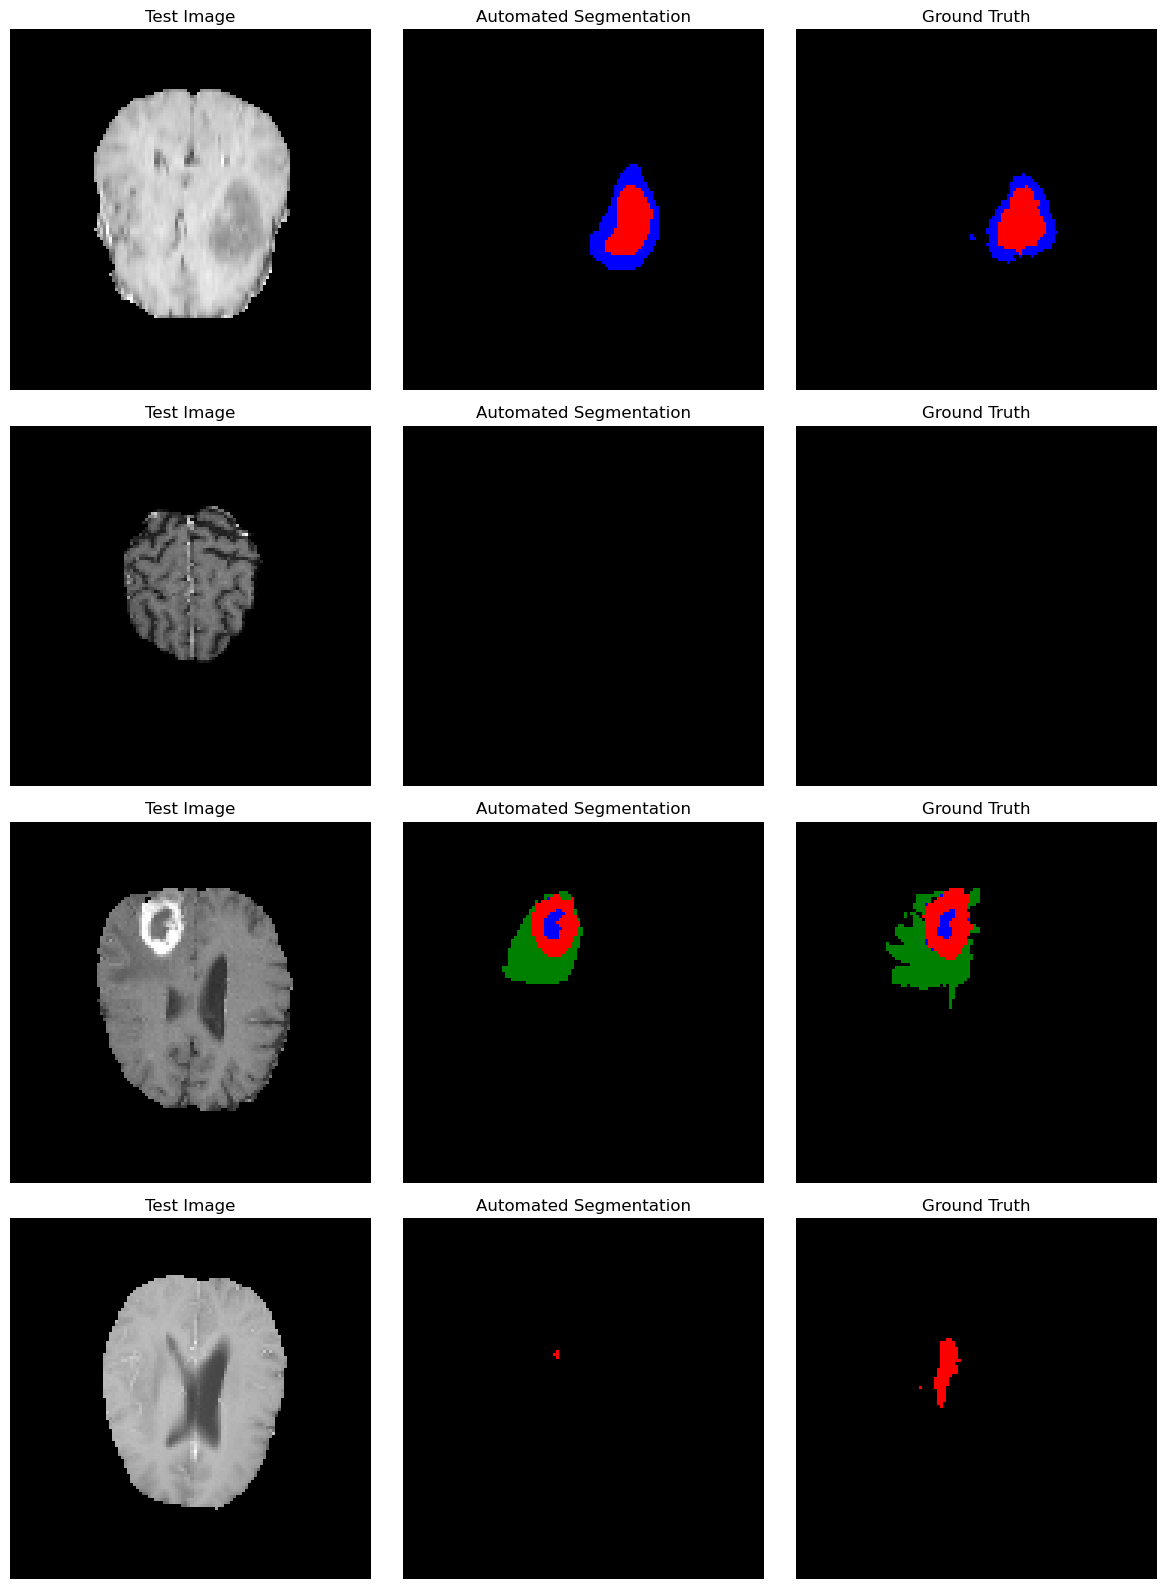

In [12]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

model_path = os.path.join(model_dir, 'model_10000.pt')
model.load_state_dict(torch.load(model_path))
model.eval()

# Disable gradient computation
torch.no_grad()

# Get a random batch of 4 test images and labels
images, labels = test_set.get_random_batch(4)

# Convert images to tensor and normalize if necessary
images_tensor = torch.from_numpy(images).to(device, dtype=torch.float32)

# Get model predictions
predictions = model(images_tensor)
predictions = torch.argmax(predictions, dim=1).cpu().numpy()

# Plotting
fig, axs = plt.subplots(4, 3, figsize=(12, 16))

for i in range(4):
    # Original Test Image
    axs[i, 0].imshow(images[i].squeeze(), cmap='gray')
    axs[i, 0].set_title('Test Image')
    axs[i, 0].axis('off')

    # Automated Segmentation (Model Prediction)
    axs[i, 1].imshow(predictions[i], cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
    axs[i, 1].set_title('Automated Segmentation')
    axs[i, 1].axis('off')

    # Ground Truth Segmentation
    axs[i, 2].imshow(labels[i].squeeze(), cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
    axs[i, 2].set_title('Ground Truth')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()

## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

## Model Evaluation
In order to verify whether the trained model works well, we consider three metrics that are often used when evaluating image segmentation models (code to calculate them is in following cell):
1. IoU (Intersection over Union): IoU is calculated as the area of overlap between the predicted segmentation and the ground truth, divided by the area of union (the total area covered by both the predicted segmentation and the ground truth). The average IoU as calculated on all the test images was 0.593. This corresponds to moderate overlap, suggesting the model is somewhat accurate but still has room for improvement.
2. Dice: The Dice coefficient measures the similarity between two samples. For image segmentation, it is calculated as twice the area of overlap between the predicted segmentation and the ground truth, divided by the sum of the areas of the predicted segmentation and the ground truth. The average Dice coefficient for the images in the test set was 0.542, again indicating moderate similarity, with the model capturing some aspects of the target segmentation but missing others.
3. Cross Entropy Loss: The cross entropy loss was the metric used to optimise the model. The metric was calculated to be 0.048 on the test set, approximately 2.4 times smaller than it was after 100 training iterations. A value of 0.048 is relatively low for cross entropy loss, suggesting that the model's predicted probabilities are, on average, close to the true class labels. 

## Potential improvements
To improve my model for clinical deployment, I would first introduce advanced data augmentation techniques, including rotations, flips, and the addition of artificial noise. These steps aim to boost the model's robustness, enabling it to  handle a broad spectrum of imaging conditions and variations encountered in clinical settings. Furthermore, I would use ensemble methods by aggregating predictions from several iterations of the model, and by doing so enhancing the overall reliability and accuracy of its predictions. To prevent overfitting and boost the model's ability to generalize to unseen data, I would implement regularisation strategies, such as dropout and L1/L2 regularisation, within the model's architecture.

Understanding the critical importance of aligning the model with clinical priorities, I would design and integrate custom loss functions that specifically prioritize minimizing errors with significant clinical implications, such as false negatives in critical disease detections. This approach ensures that the model's learning process is directly tied to outcomes that matter most in a healthcare context.

In [14]:
def calc_iou(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    union_sum = np.sum(union)
    if union_sum == 0:
        return 1.0 if np.sum(intersection) == 0 else 0
    iou_score = np.sum(intersection) / union_sum
    return iou_score

def calc_dice(target, prediction):
    intersection = np.logical_and(target, prediction)
    sum_target_prediction = np.sum(target) + np.sum(prediction)
    if sum_target_prediction == 0:
        return 1.0
    dice_score = 2 * np.sum(intersection) / sum_target_prediction
    return dice_score

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

iou_scores = []
dice_scores = []
cross_entropy_losses = []

criterion = torch.nn.CrossEntropyLoss()

# Iterate over test images
for idx in range(len(test_set)):
    # Get the image and label
    image, label = test_set[idx]
    # Add batch and channel dimensions
    image = image.reshape(1, 1, image.shape[0], image.shape[1])
    # Add batch dimension
    label = label.reshape(1, label.shape[0], label.shape[1])

    image_tensor = torch.from_numpy(image).to(device, dtype=torch.float32)
    label_tensor = torch.from_numpy(label).to(device, dtype=torch.long)

    with torch.no_grad():
        logits = model(image_tensor)
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        loss = criterion(logits, label_tensor.squeeze(1))
        
    # Calculate metrics
    iou_score = calc_iou(label_tensor.cpu().numpy().squeeze(), predictions.squeeze())
    dice_score = calc_dice(label_tensor.cpu().numpy().squeeze(), predictions.squeeze())
    
    # Store metrics
    iou_scores.append(iou_score)
    dice_scores.append(dice_score)
    cross_entropy_losses.append(loss.item())

# Calculate average metrics
average_iou = np.mean(iou_scores)
average_dice = np.mean(dice_scores)
average_loss = np.mean(cross_entropy_losses)

print(f"Average IoU: {average_iou:.3f}")
print(f"Average Dice: {average_dice:.3f}")
print(f"Average Cross Entropy Loss: {average_loss:.3f}")

Average IoU: 0.593
Average Dice: 0.542
Average Cross Entropy Loss: 0.048
